# Segmentation of credit card users

## Introduction

### Data and purpose of the study

Data is prepared to analyse clusters of customers and their behaviour in relation to credit card use. The aim is to segment credit card customers into an appropriate number of groups according to customer behaviour in order to achieve an effective and efficient credit card marketing strategy.

### Choice of research method

The k-means method is a useful technique for segmenting credit card users, as it allows the identification of distinct groups or clusters in a dataset based on their similarities and differences. In the context of credit card users, customer segmentation can provide valuable information and benefits for a variety of reasons:

1. **Customer profiling**: By segmenting credit card users, you can gain a deeper understanding of their characteristics, behaviours and preferences. This can help create detailed customer profiles that can be used to tailor marketing strategies, develop personalised offers and improve customer satisfaction.
2. **Targeted marketing**: Segmenting customers based on their spending patterns or usage habits allows credit card companies to target specific customer segments with tailored marketing campaigns. This helps optimise marketing resources and increases the likelihood of reaching the right audience with relevant offers and promotions.
3. **Risk assessment**: Credit card companies can use segmentation to assess the risks associated with different customer segments. By analysing factors such as payment history or credit usage, they can identify high-risk segments and implement appropriate risk management strategies.

In [ ]:
#!pip install -U ydata-profiling
#!pip install numpy
#!pip install pandas
#!pip install seaborn
#!pip install scipy
#!pip install matplotlib
#!pip install -U scikit-learn
#!pip install collections
#!pip install tabulate
#!pip install kneed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from collections import Counter
from tabulate import tabulate
from kneed import KneeLocator

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option("display.precision", 3)

## Data description

- CUST_ID: Identification number of the credit card holder
- BALANCE: Amount of balance remaining on the account for purchases
- BALANCE_FREQUENCY : How often the balance is updated, score from 0 to 1 (1 = often updated, 0 = rarely updated)
- PURCHASES : Amount of purchases made from the account
- ONEOFF_PURCHASES : Maximum amount of purchases made at one time
- INSTALLMENTS_PURCHASES : Amount of purchases made in instalments
- CASH_ADVANCE : Cash advance transferred by the user
- PURCHASES_FREQUENCY : How often purchases are made, score from 0 to 1 (1 = frequent purchases, 0 = infrequent purchases)
- ONEOFF_PURCHASES_FREQUENCY : How often one-off purchases are made (1 = frequently purchased, 0 = rarely purchased)
- PURCHASES_INSTALLMENTS_FREQUENCY : How often instalment purchases are made (1 = frequently purchased, 0 = rarely purchased)
- CASH_ADVANCE_FREQUENCY : How often is a cash loan paid?
- CASH_ADVANCE_TRX: Number of transactions made using the cash advance option
- PURCHASES_TRX: Number of purchase transactions made
- CREDIT_LIMIT: Credit card limit for the user
- PAYMENTS : Amount of payments made by the user
- MINIMUM_PAYMENTS : Minimum amount of payments made by the user
- PRC_FULL_PAYMENT : Percentage of the full payment made by the user
- TENURE : Period of use of the credit card by the user

A cash advance is a short-term cash loan - an expensive one - taken out as part of a credit line on a credit card.

## EDA

In [3]:
df = pd.read_csv('data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

The column with the customer ID will not be needed.

In [4]:
df.drop(columns='CUST_ID', inplace=True)

### Distributions of variables

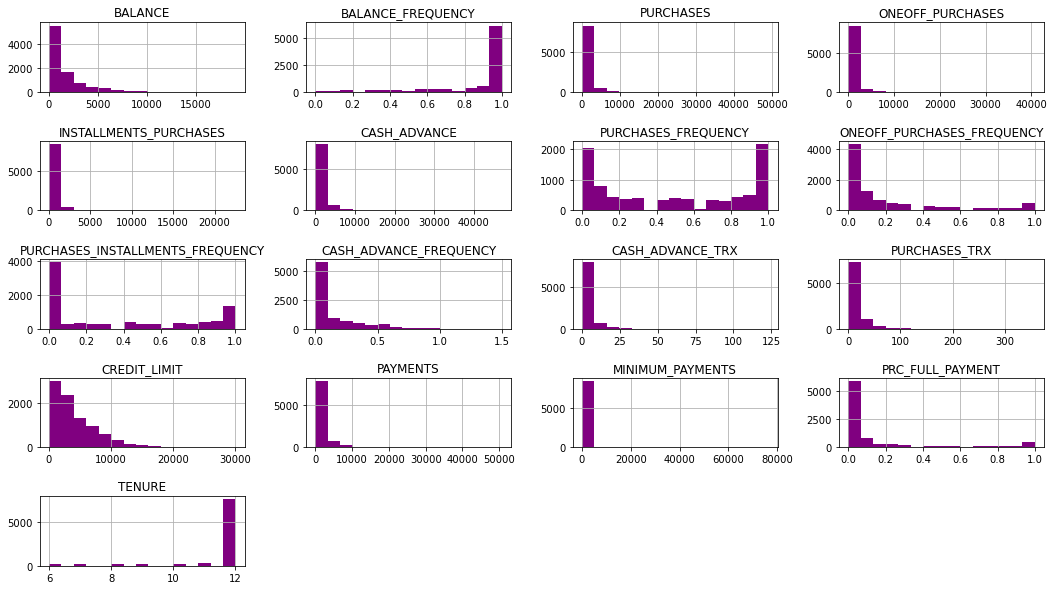

In [5]:
df.hist(bins=15, figsize=(18, 10), color='purple')
plt.subplots_adjust(hspace=0.7)
plt.show()

In [6]:
import warnings

warnings.filterwarnings('ignore')

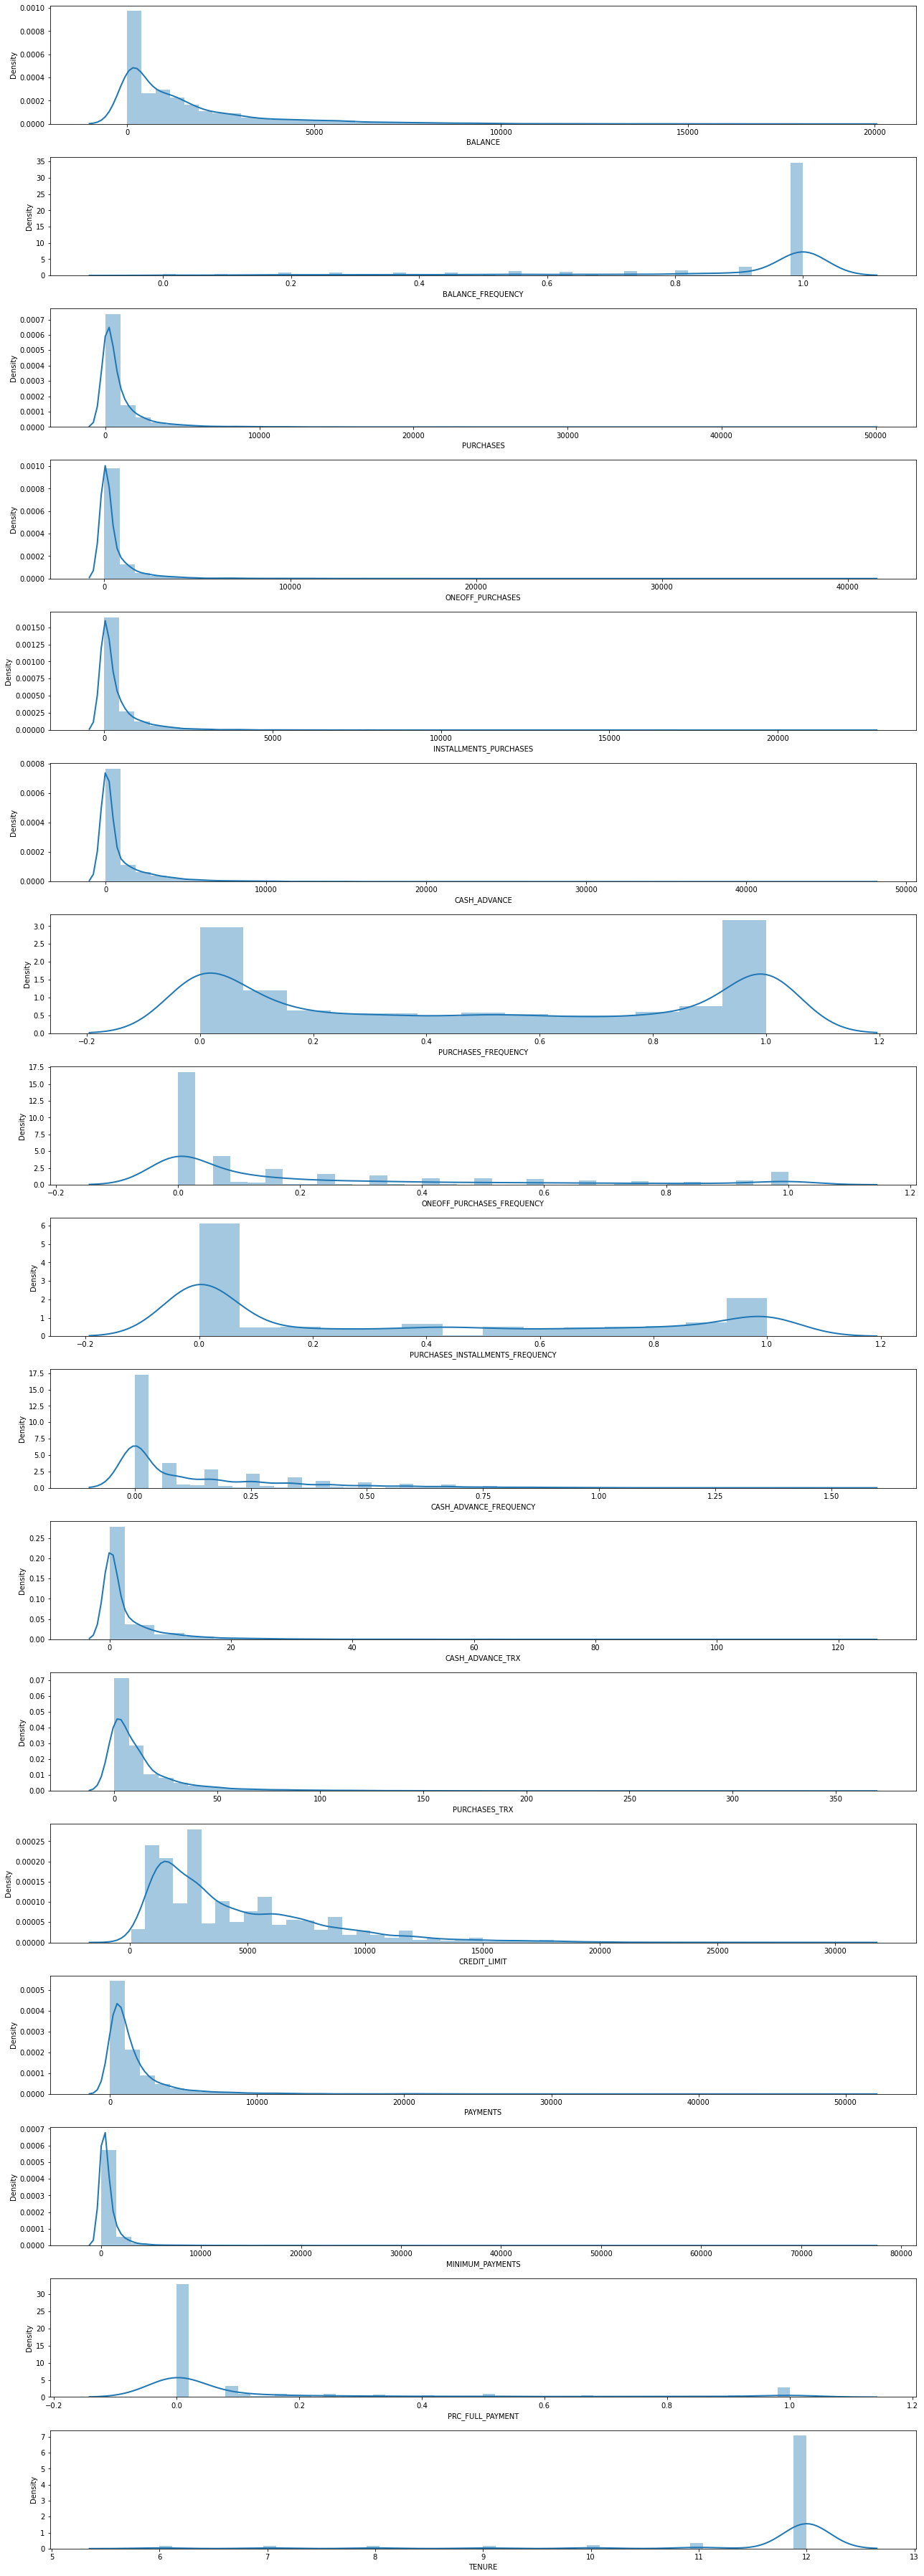

In [7]:
plt.figure(figsize=(18, 50))
for i in range(len(df.columns)):
    plt.subplot(len(df.columns), 1, i + 1)
    sns.distplot(df[df.columns[i]], kde_kws={'lw': 2, 'label': 'KDE'})
plt.tight_layout()

The vast majority of distributions are right-skewed.

### Correlation analysis

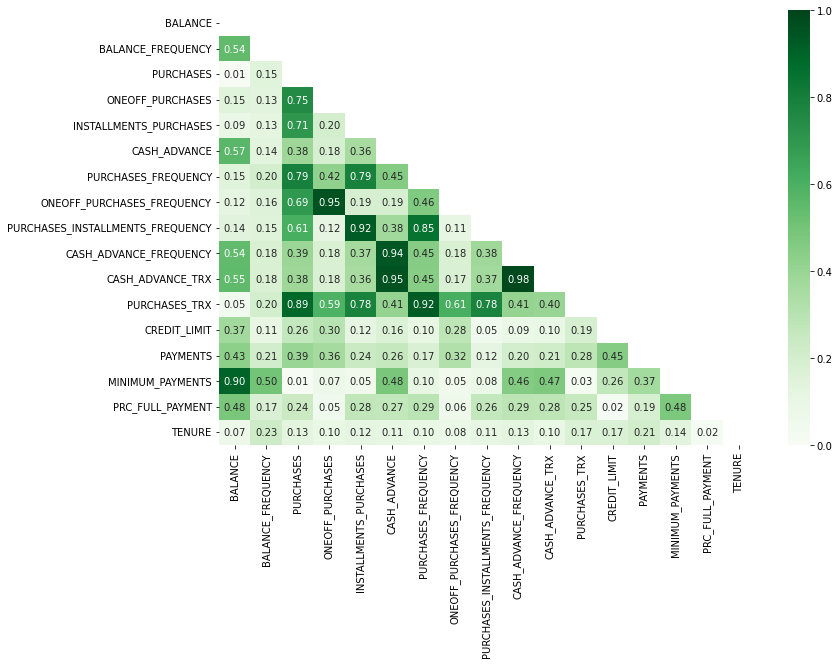

In [8]:
corr = df.corr(method='spearman').abs()

sns.heatmap(corr,
            vmin=0,
            vmax=1,
            cmap='Greens',
            mask=np.triu(corr),
            fmt='.2f',
            annot=True)

plt.show()

Conclusions of the basic analysis:

- Many columns have a substantial number of zeros, which means, among other things, that many customers do not buy anything with the card, It is worth mentioning that there are a lot of customers with a balance value close to or equal to zero - it can be assumed that they keep their balance low in order to obtain, among other things, a high credit rating
- In a significant number, the distributions of the variables are right-skewed (for example, balance), i.e. the mean significantly exceeds the median
- Some of the columns are highly correlated with each other, most of which the association is quite logical, such as the number of transactions via cash advance and the frequency of use of cash advance

In [9]:
df['TENURE'].value_counts().sort_index()

6      204
7      190
8      196
9      175
10     236
11     365
12    7584
Name: TENURE, dtype: int64

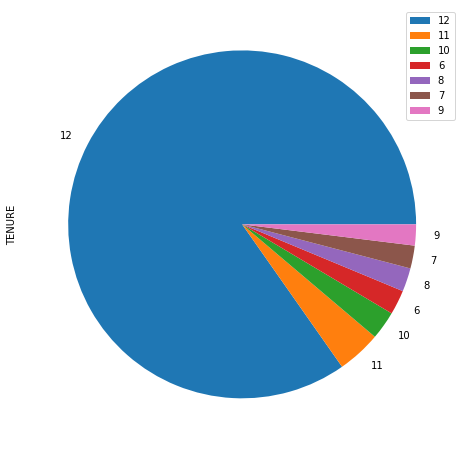

In [10]:
df['TENURE'].value_counts().plot.pie(figsize=(8, 8))
plt.legend()
plt.show()

The vast majority of clients prefer a useful life of a full year.

In [12]:
purchase_cols = [col for col in df.columns if col.find('PURCHASE') != -1]

df.groupby('TENURE').mean()[purchase_cols]

,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX
TENURE,,,,,,,
6,443.942,266.917,177.172,0.463,0.142,0.301,5.691
7,424.559,244.052,180.507,0.430,0.123,0.292,5.668
8,468.859,305.399,163.460,0.406,0.141,0.274,6.250
9,540.138,302.211,239.470,0.406,0.109,0.297,6.571
10,676.631,407.239,269.592,0.390,0.142,0.263,7.826
11,571.222,370.301,200.922,0.360,0.148,0.232,7.858
12,1088.192,640.491,448.010,0.506,0.214,0.381,16.129


The users with the longest credit card tenure are more willing to spend money on purchases - both in terms of how much money they have and how often they spend it.

## Cluster analysis

### Data transformation

#### Scaling and data imputation

As both *KNNImputer* and the k-means method require scaling, the scaling will be done first and then the imputation.

In [22]:
df.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [23]:
df[['CREDIT_LIMIT', 'MINIMUM_PAYMENTS']].describe()[1:].T

,mean,std,min,25%,50%,75%,max
CREDIT_LIMIT,4494.449,3638.816,50.000,1600.000,3000.000,6500.000,30000.000
MINIMUM_PAYMENTS,864.207,2372.447,0.019,169.124,312.344,825.485,76406.208


In [24]:
df_std = df.copy(deep=True)

In [25]:
sc = StandardScaler()
df_std.loc[:, :] = sc.fit_transform(df_std)
knn_imputer = KNNImputer()
df_std.loc[:, :] = knn_imputer.fit_transform(df_std)

In [26]:
df_std.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.732,-0.249,-0.425,-0.357,-0.349,-0.467,-0.806,-0.679,-0.707,-0.675,-0.476,-0.511,-0.960,-0.529,-0.305,-0.526,0.361
1,0.787,0.134,-0.470,-0.357,-0.455,2.606,-1.222,-0.679,-0.917,0.574,0.110,-0.592,0.689,0.819,0.088,0.234,0.361
2,0.447,0.518,-0.108,0.109,-0.455,-0.467,1.270,2.673,-0.917,-0.675,-0.476,-0.109,0.826,-0.384,-0.100,-0.526,0.361
3,0.049,-1.017,0.232,0.546,-0.455,-0.369,-1.014,-0.399,-0.917,-0.259,-0.330,-0.552,0.826,-0.599,-0.277,-0.526,0.361
4,-0.359,0.518,-0.462,-0.347,-0.455,-0.467,-1.014,-0.399,-0.917,-0.675,-0.476,-0.552,-0.905,-0.364,-0.261,-0.526,0.361


### Number of clusters choice

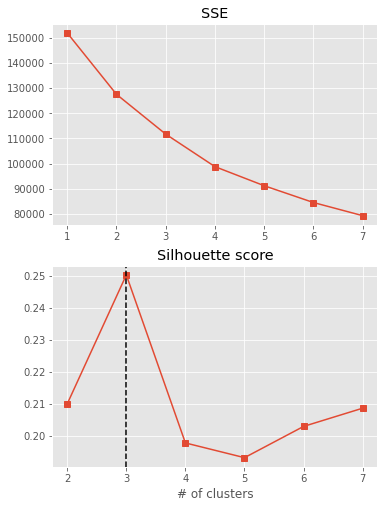

In [27]:
SSE = []
for k in range(1, 8):
    km = KMeans(n_clusters=k, init='k-means++', random_state=15, n_init=15)
    km.fit(df_std)
    SSE.append(km.inertia_)

score = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, init='k-means++', random_state=15, n_init=15)
    results_km = km.fit(df_std)
    coefficient = silhouette_score(df_std, results_km.labels_)
    score.append(coefficient)

with plt.style.context('ggplot'):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5.5, 7))
    fig.tight_layout(pad=2)
    ax1.plot(range(1, 8), SSE, marker='s')
    ax1.set_title('SSE')
    ax2.plot(range(2, 8), score, marker='s')
    ax2.axvline(x=np.argmax(score) + 2, linestyle='dashed', color='black')
    ax2.set_title('Silhouette score')
    plt.xlabel('# of clusters')
plt.show()

### K-Means Method

In [28]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=15)

results = kmeans.fit(df_std)

In [29]:
df_results = pd.DataFrame(results.cluster_centers_, columns=df_std.columns)

In [30]:
random_colors = [
    '#18e6c0', '#abbc0f', '#d9aeab', '#4879f3', '#71bd03', '#f682e0',
    '#191330', '#bbb3a9', '#e6f80b', '#0352b1', '#cb8415', '#d7abe6',
    '#35917a', '#2a6512', '#6eeb8f', '#c23d38', '#75ebc8'
]

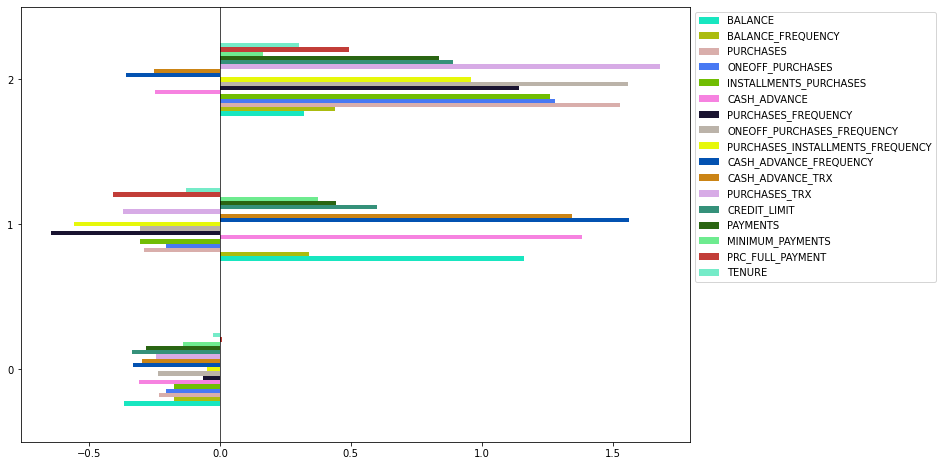

In [33]:
df_results.plot.barh(color=random_colors)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.axvline(x=0, color='#000000', linewidth=0.7)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [34]:
df_full = pd.DataFrame(sc.inverse_transform(df_std), columns=df.columns)

df_full['cluster'] = results.labels_

df_full.groupby('cluster').mean()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,801.355,0.835,505.520,253.135,252.706,329.659,0.465,0.132,0.345,0.068,1.210,8.657,3270.553,909.869,525.218,0.156,11.480
1,3981.201,0.958,382.390,248.331,134.137,3877.477,0.231,0.111,0.143,0.448,12.419,5.533,6679.714,3020.062,1754.692,0.034,11.346
2,2230.303,0.982,4264.857,2714.253,1551.089,460.880,0.949,0.667,0.745,0.063,1.537,56.471,7735.610,4150.678,1251.175,0.298,11.923


In [35]:
from numpy.typing import ArrayLike

summary_tbl = pd.DataFrame(
    columns=['model', 'davies_bouldin', 'silhouette', 'calinski_harabasz'])

SCORE_LIST = [davies_bouldin_score, silhouette_score, calinski_harabasz_score]


def add_scores(data: pd.DataFrame, labels: ArrayLike, table: pd.DataFrame,
               model: str):

    results = []

    for score in SCORE_LIST:

        results.append(score(data, labels))

    table.loc[len(table)] = [model, *results]

    return table


summary_tbl = add_scores(df_std, results.labels_, summary_tbl, 'k-means')

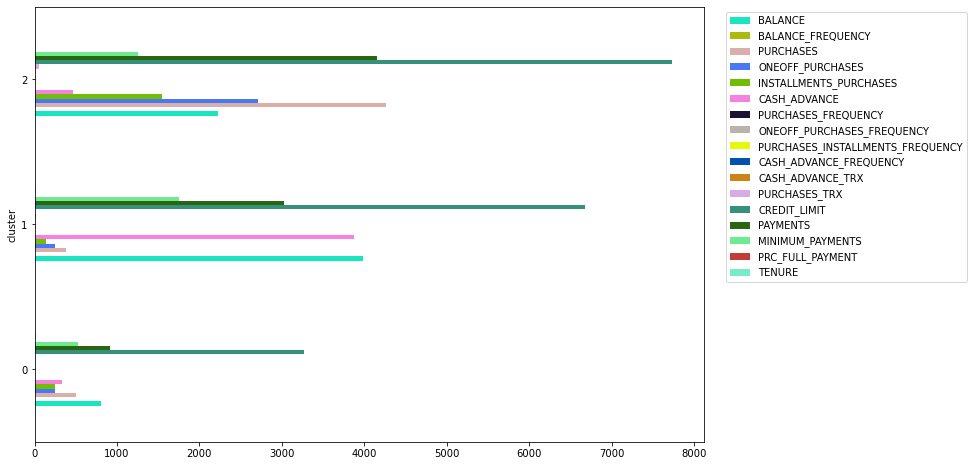

In [41]:
df_full.groupby('cluster').mean().plot.barh(color=random_colors)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.show()

In [42]:
Counter(results.labels_)

Counter({0: 6121, 1: 1592, 2: 1237})

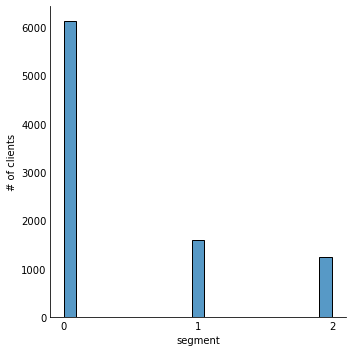

In [43]:
with plt.style.context('_mpl-gallery-nogrid'):
    sns.displot(df_full, x="cluster")
    plt.xticks(range(3))
    plt.xlabel('segment')
    plt.ylabel('# of clients')
plt.show()

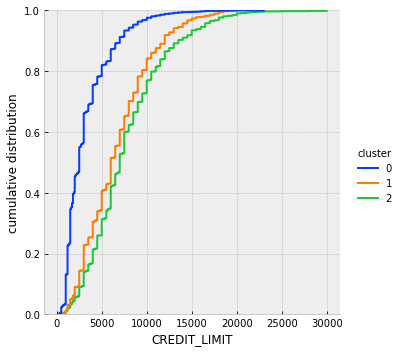

In [45]:
with plt.style.context('bmh'):
    sns.displot(df_full,
                x="CREDIT_LIMIT",
                hue="cluster",
                kind="ecdf",
                palette='bright')
    plt.ylabel('cumulative distribution')
plt.show()

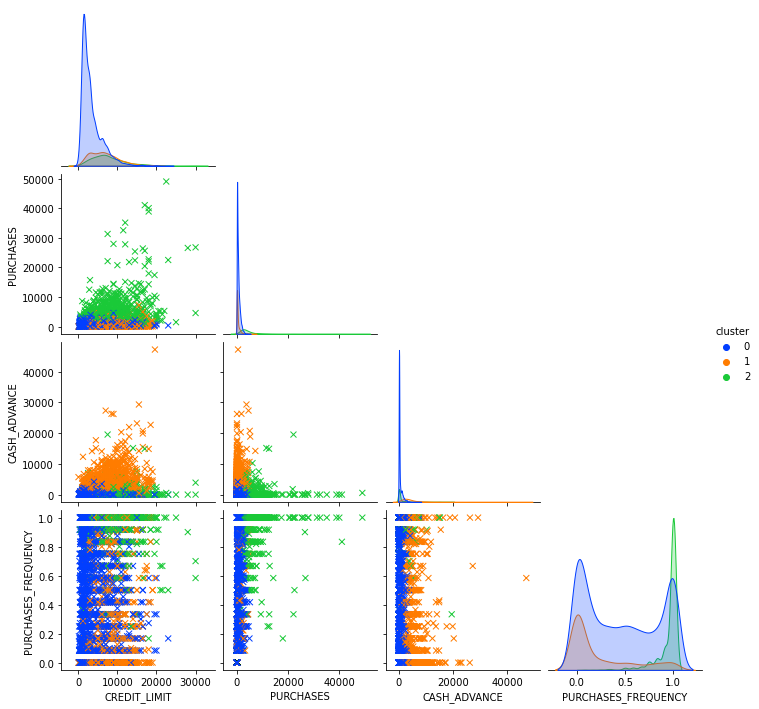

In [48]:
sns.pairplot(df_full[[
    'CREDIT_LIMIT', 'PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
    'cluster'
]],
             hue='cluster',
             corner=True,
             plot_kws=dict(marker="x", linewidth=1),
             palette='bright')
plt.show()

### DBSCAN

In [49]:
min_pts = len(list(df_std)) * 2
min_pts

34

In [50]:
nn_m = NearestNeighbors(n_neighbors=min_pts)
neighbors_m = nn_m.fit(df_std)

In [51]:
distances_m = neighbors_m.kneighbors(df_std)[0][:, -1]

distances_sorted_desc = sorted(distances_m, reverse=True)

5.883874739228437


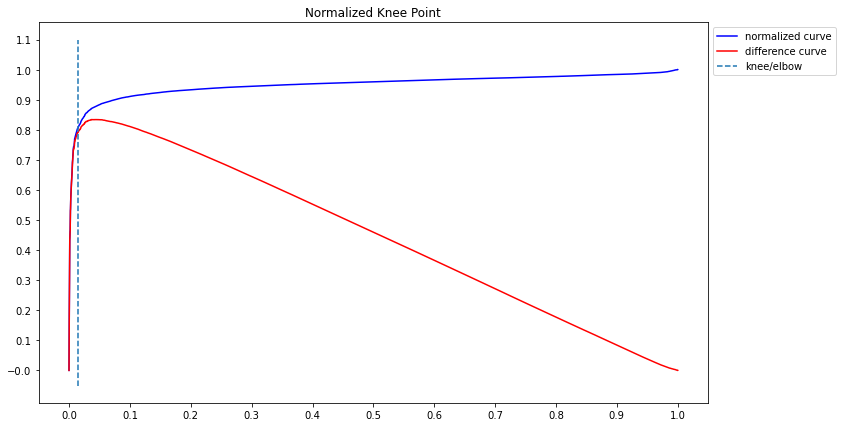

In [52]:
kneedle = KneeLocator(
    range(1,
          len(distances_sorted_desc) + 1),
    distances_sorted_desc,
    S=1.0,  #parameter suggested from paper
    curve="convex",  #parameter from figure
    direction="decreasing")  #parameter from figure

kneedle.plot_knee_normalized(figsize=(12, 7))
plt.legend(bbox_to_anchor=(1, 1))

epsilon = kneedle.knee_y
print(epsilon)  # optimal epsilon value

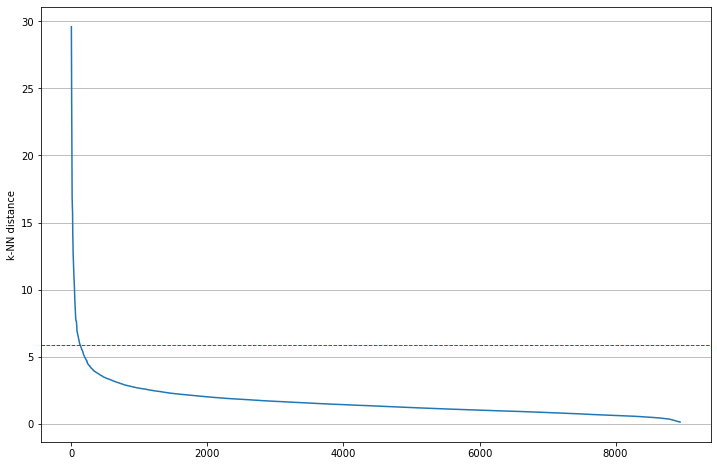

In [53]:
plt.plot(distances_sorted_desc)
plt.ylabel('k-NN distance')
plt.grid(axis='y')
plt.axhline(y=epsilon, linestyle='--', linewidth=0.95, color='red')
plt.show()

In [54]:
dbscan_m = DBSCAN(eps=epsilon, min_samples=min_pts)
dbscan_m.fit(df_std)

DBSCAN(eps=5.883874739228437, min_samples=34)

In [55]:
labels_m = dbscan_m.labels_
Counter(labels_m)

Counter({0: 8894, -1: 56})

In [56]:
summary_tbl = add_scores(df_std, labels_m, summary_tbl, 'dbscan')

In [57]:
df_std['cluster'] = labels_m

df_std.groupby('cluster').mean()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
-1,2.337,0.367,6.397,5.577,4.877,2.473,0.700,1.002,0.746,0.692,2.305,3.186,2.465,6.186,4.004,0.424,1.338e-01
0,-0.015,-0.002,-0.040,-0.035,-0.031,-0.016,-0.004,-0.006,-0.005,-0.004,-0.015,-0.020,-0.016,-0.039,-0.034,-0.003,-8.427e-04


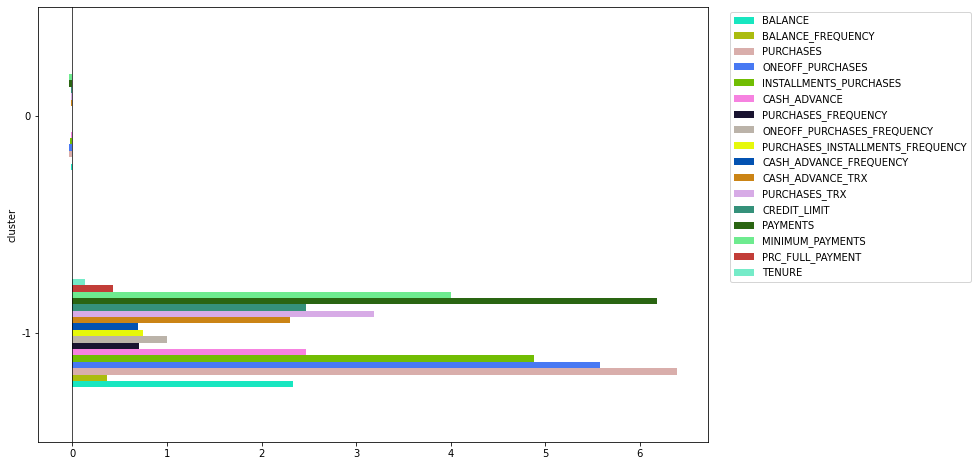

In [59]:
df_std.groupby('cluster').mean().plot.barh(color=random_colors)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.axvline(x=0, color='#000000', linewidth=0.7)
plt.show()

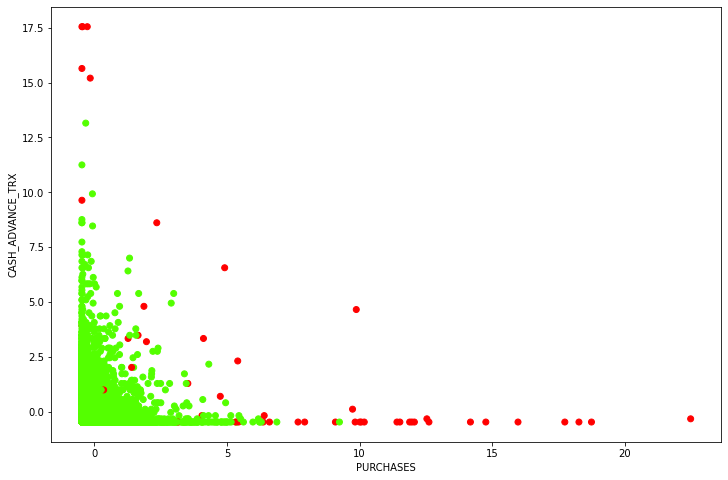

In [61]:
plt.scatter(df_std['PURCHASES'],
            df_std['CASH_ADVANCE_TRX'],
            c=labels_m,
            cmap='prism')
plt.xlabel('PURCHASES')
plt.ylabel('CASH_ADVANCE_TRX')
plt.show()

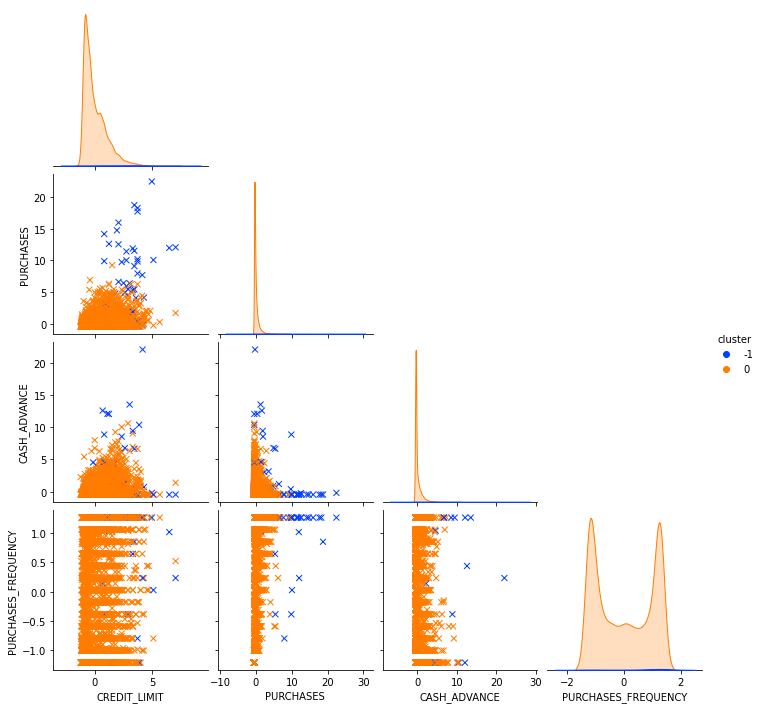

In [62]:
sns.pairplot(df_std[[
    'CREDIT_LIMIT', 'PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
    'cluster'
]],
             hue='cluster',
             corner=True,
             plot_kws=dict(marker="x", linewidth=1),
             palette='bright')

df_std.drop(columns='cluster', inplace=True)

### Ward Method

In [68]:
clust_data = linkage(df_std, method='ward')

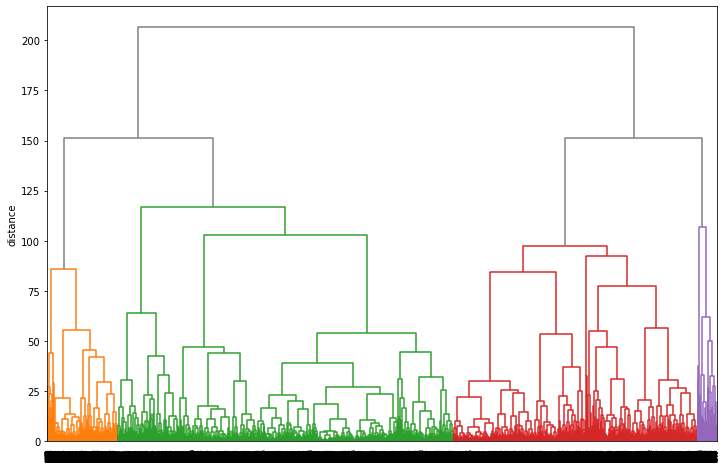

In [69]:
dendrogram(
    clust_data,
    leaf_rotation=90,
    labels=df_std.index,
    above_threshold_color='gray')

plt.ylabel('distance')
plt.show()

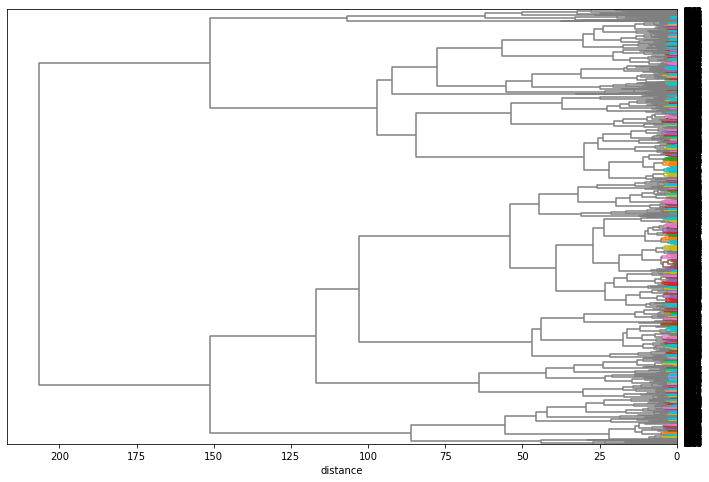

In [70]:
dendrogram(clust_data,
           leaf_rotation=0,
           labels=df_std.index,
           orientation='left',
           leaf_font_size=7,
           color_threshold=5,
           above_threshold_color='gray')
plt.xlabel('distance')
plt.show()

In [71]:
clusters = cut_tree(clust_data, n_clusters=6)

In [72]:
Counter([cluster[0] for cluster in clusters])

Counter({0: 3667, 1: 941, 2: 3266, 3: 230, 4: 823, 5: 23})

In [73]:
summary_tbl = add_scores(df_std, [cluster[0] for cluster in clusters],
                         summary_tbl, 'ward')

In [74]:
df_std['cluster'] = clusters

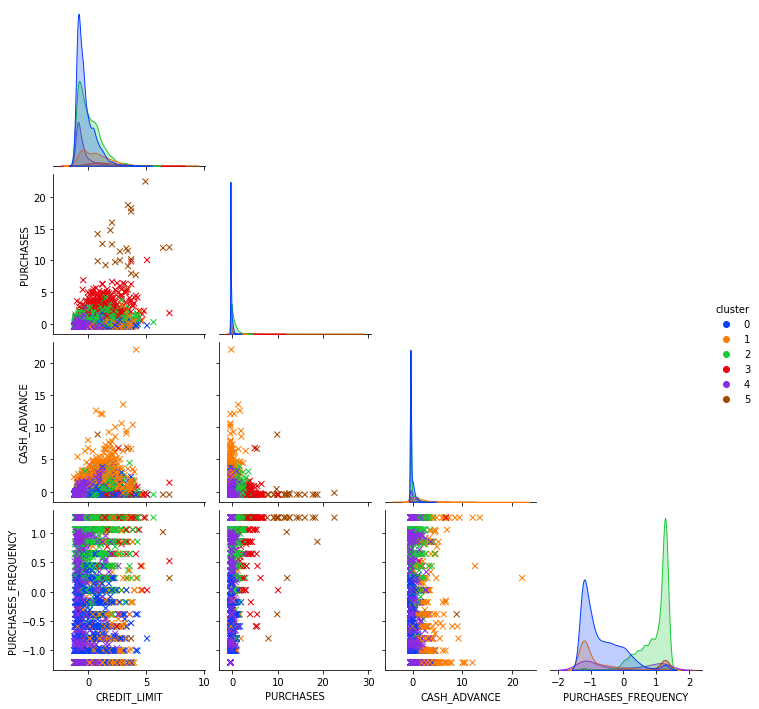

In [76]:
sns.pairplot(df_std[[
    'CREDIT_LIMIT', 'PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
    'cluster'
]],
             hue='cluster',
             corner=True,
             plot_kws=dict(marker="x", linewidth=1),
             palette='bright')
plt.show()

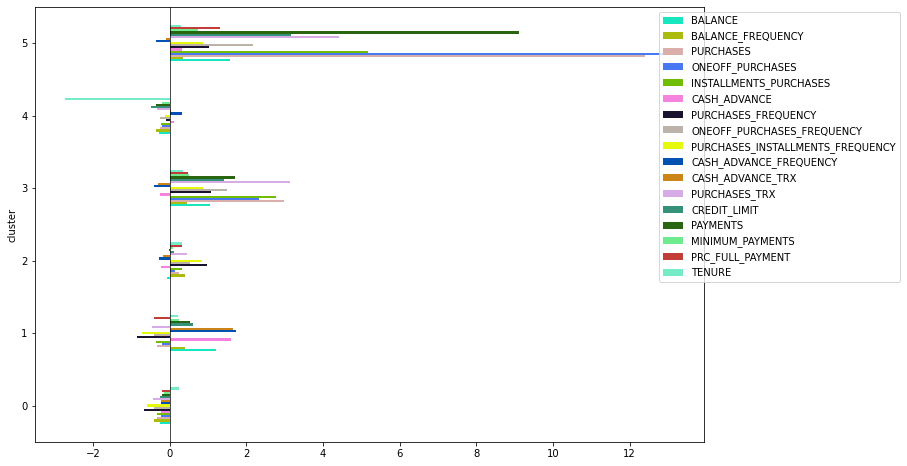

In [77]:
df_std.groupby('cluster').mean().plot.barh(color=random_colors)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.axvline(x=0, color='#000000', linewidth=0.7)
plt.show()

Explained variance (two dimensions): 47.69%


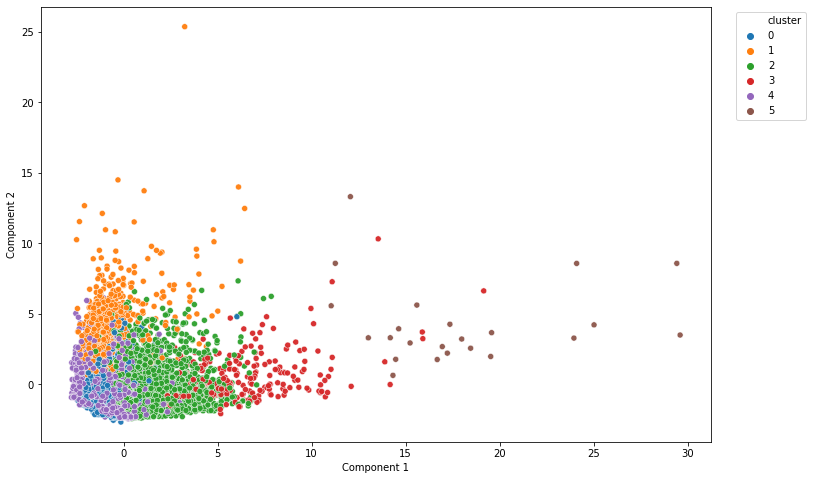

In [78]:
pca = PCA()
results_pca = pca.fit_transform(df_std.iloc[:, :-1])

components = pd.DataFrame(
    results_pca,
    columns=[f'Component {i}' for i in range(1, results_pca.shape[1] + 1)])
components['cluster'] = df_std['cluster']

explained_var_cumsum = np.cumsum(pca.explained_variance_ratio_)

print(
    f'Explained variance (two dimensions): {explained_var_cumsum[1]*100:.2f}%'
)

plt.plot([], [], ' ', label='cluster')

sns.scatterplot(x='Component 1',
                y='Component 2',
                data=components,
                alpha=0.95,
                hue='cluster',
                palette='tab10')

plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()

In [79]:
print(
    tabulate(summary_tbl,
             headers='keys',
             tablefmt='fancy_grid',
             showindex=False,
             floatfmt='.2f'))

╒═════════╤══════════════════╤══════════════╤═════════════════════╕
│ model   │   davies_bouldin │   silhouette │   calinski_harabasz │
╞═════════╪══════════════════╪══════════════╪═════════════════════╡
│ k-means │             1.59 │         0.25 │             1608.97 │
├─────────┼──────────────────┼──────────────┼─────────────────────┤
│ dbscan  │             1.38 │         0.76 │              663.98 │
├─────────┼──────────────────┼──────────────┼─────────────────────┤
│ ward    │             1.52 │         0.17 │             1066.17 │
╘═════════╧══════════════════╧══════════════╧═════════════════════╛
